<a href="https://colab.research.google.com/github/KIIIIT00/B3_Spring/blob/add%2FGoogleColab/MNIST_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **B3_Spring** ###


In [20]:
# ライブラリのインストール
!pip install torch torchvision tensorflow

In [40]:
# 必要なライブラリをインポート
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tensorflow.keras.datasets import mnist
import math
import matplotlib.pyplot as plt
import numpy as np

In [22]:
# CNNの定義
class MNIST_CNN(nn.Module):
  def __init__(self):
    super(MNIST_CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1,
                           out_channels=16,
                           kernel_size=3,
                           padding=1)
    self.conv2 = nn.Conv2d(in_channels=16,
                           out_channels=32,
                           kernel_size=3,
                           padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(32 * 14 * 14, 128)
    self.fc2 = nn.Linear(128, 10)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.pool(self.relu(self.conv2(x)))
    x = x.view(x.size(0), -1)
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    return x

  def save_model(self, model_name):
    model_path = f'{model_name}.pth'
    torch.save(self.state_dict(), model_path)

  def load_model(self, model_name):
    model_path = f'{model_name}.pth'
    if os.path.exists(model_path):
      self.load_state_dict(torch.load(model_path))
      print("Model loaded successfully")
    else:
      print("Model not found")

In [23]:
# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MNISTデータをロード
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# データの前処理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

x_train = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1) / 255.0
y_train = torch.tensor(y_train, dtype=torch.long)
x_test = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1) / 255.0
y_test = torch.tensor(y_test, dtype=torch.long)

# DataLoaderの作成
batch_size = 64
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# モデルの作成
model = MNIST_CNN().to(device)

# 損失関数とオプティマイザの設定
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 学習ループ
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")

# モデルを保存
model.save_model("mnist_cnn")

# モデルの評価
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Epoch 1/5, Loss: 0.1964
Epoch 2/5, Loss: 0.0535
Epoch 3/5, Loss: 0.0353
Epoch 4/5, Loss: 0.0236
Epoch 5/5, Loss: 0.0187
Test Accuracy: 98.58%


In [45]:
def show_mnist_images(images, labels, predictions=None):
  """
  MNIST画像を複数表示する関数
  """
  num_images = len(images)
  cols = min(5, num_images)
  rows = math.ceil(num_images / cols)

  plt.figure(figsize=(cols * 2, rows * 2))
  for i in range(num_images):
        img = images[i].cpu().numpy().squeeze()  # [1,28,28] → [28,28]
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")

        title = f"Label: {labels[i].item()}"
        if predictions is not None:
            title += f"\nPred: {predictions[i].item()}"
        plt.title(title)

  plt.show()

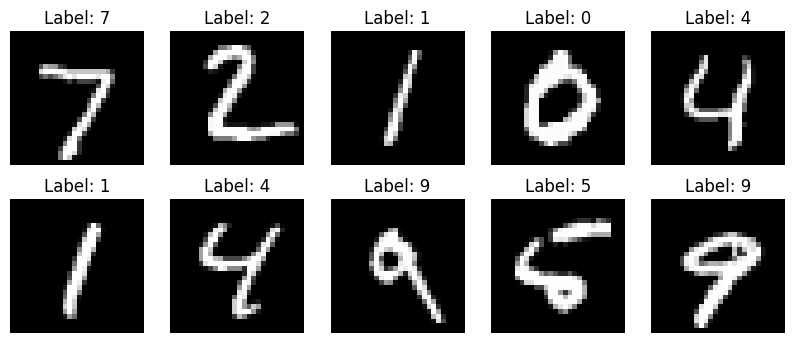

In [47]:
images, labels = zip(*[test_dataset[i] for i in range(10)])
images = torch.stack(images).to(device)

# 画像を表示（予測なし）
show_mnist_images(images, labels)